## Многокритериальный поиск - ЛР 7

In [1]:
import Pkg
Pkg.add("Plots")
using Plots
Pkg.add("LinearAlgebra")

   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`


In [2]:
func(x, y) = (x-4*y)^2 +(y+5)^2
f(x) = func(x[1],x[2])
x0 = [10.0, -5.0] 

2-element Vector{Float64}:
 10.0
 -5.0

In [3]:
using LinearAlgebra
function df(f, x::Vector{Float64}, i, h=1e-5)
    x_plus = copy(x)
    x_minus = copy(x)
    
    x_plus[i] += h
    x_minus[i] -= h
    
    df_dx = (f(x_plus) - f(x_minus)) / (2h)
    
    return df_dx
end

function gradient(f, x::Vector{Float64})
    grad = []
    for i in 1:length(x)
        push!(grad, df(f, x, i))
    end
    return grad
end

gradient (generic function with 1 method)

In [4]:
using LinearAlgebra

function swann_method(f, x0, h=0.1)
    first = x0
    second = x0 + h
    # если функция растет, меняем направление движения
    if f(second) > f(first)
        h = -h
        first, second = second, second + h
    end
    last = second + h
    
    # увеличиваем шаг движения, если функция уменьшается
    while f(last) < f(second)
        h *= 2
        first, second, last = second, last, last + h
    end
    # перепрыгнули далеко
    if second > last
        first, second, last = last, second, first
    end

    return first, last
end

swann_method (generic function with 2 methods)

In [5]:
using LinearAlgebra

function golden_section_search(f, a, b, eps=1e-5)
    phi = (sqrt(5) - 1) / 2 
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    
    while abs(b - a) > eps
        if f(x1) <= f(x2)
            b = x2
        else
            a = x1
        end
        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
    end
    
    return (a + b) / 2
end

golden_section_search (generic function with 2 methods)

In [6]:
function conjugate_gradient(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    grad = gradient(f, x)
    d = -grad
    trajectory = [x]
    
    while true
        prev_grad=copy(grad)
        l, r = swann_method(alpha -> f(x + alpha * d), 1e-7)
        alpha = golden_section_search(alpha -> f(x + alpha * d), l, r)
        x += alpha * d
        grad = gradient(f, x)

        if norm(x - prev_x) < eps1 || norm(f(x) - f(prev_x)) < eps2
            break
        end

        beta = dot(grad, grad) / dot(prev_grad, prev_grad)
        d = -grad + beta * d
        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

x_min, trajectory = conjugate_gradient(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [-20.00000002844816, -5.0000000067147665]; Количество итераций: 5

In [7]:
using ForwardDiff

function multicriterial_search(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    trajectory = [x]
    n = 2
    i = 0
    while true        
        i += 1
        grad = gradient(f, x)
        delta = x - prev_x
        
        if mod(i, n) == 0
            delta = Vector{Float64}([0, 0])
        end
        
        g = a -> f(x - a[1] * grad + a[2] * delta)
        
        a_k, tr = conjugate_gradient(g, prev_x)
        x, prev_x = x - a_k[1] * grad + a_k[2] * delta, x
        
        if norm(f(x) - f(prev_x)) < eps1
            break
        end

        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

x_min, trajectory = multicriterial_search(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [-19.999434787694668, -4.999866543741883]; Количество итераций: 8

Многокритериальный поиск:
 точка минимума: [-19.999434787694668, -4.999866543741883]
 кол-во итераций = 8


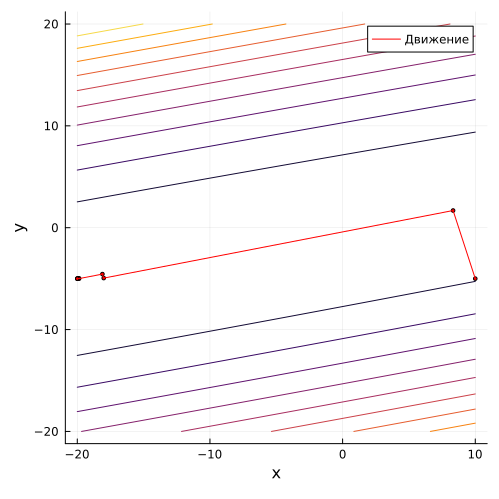

In [8]:
func(x, y) = (x-4*y)^2 +(y+5)^2
f(x) = func(x[1],x[2])
x0 = [10.0, -5.0] 

x = -20:0.1:10
y = -20:0.1:20
x_min, trajectory = multicriterial_search(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("Многокритериальный поиск:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

In [14]:
using ForwardDiff

xhistory = Array{Float64}([])
yhistory = Array{Float64}([])

function _sven(f::Function, start::Vector{Float64}, dir::Vector{Float64})
    dir = dir / norm(dir, 2)

    a, b, c = start, start, start
    fa, fb, fc = f(start), f(start), f(start)
    step = 1 / 2^13

    while fc <= fb
        c, b, a = c + step * dir, c, b
        fc, fb, fa = f(c), fc, fb
        step *= 2
    end

    return [a, c]
end


function _find_min_by_direction(
    f::Function,
    interval::Vector{Vector{Float64}},
    prec::Float64)
    a, b = interval[1], interval[2]

    fib1 = 1
    fib2 = 1
    fib3 = fib1 + fib2
    while norm(b - a) / prec > fib3
        fib1 = fib2
        fib2 = fib3
        fib3 = fib1 + fib2
    end

    y = a + fib1 / fib3 * (b - a)
    z = a + fib2 / fib3 * (b - a)
    while true
        fy = f(y)
        fz = f(z)


        fib1 = fib2 - fib1
        fib2 = fib2 - fib1
        fib3 = fib1 + fib2

        if fy <= fz
            b = z
            z = y
            y = a + fib1 / fib3 * (b - a)
        else
            a = y
            y = z
            z = a + fib2 / fib3 * (b - a)
        end

        if fib1 < 1
            res = (y + z) / 2
            return res
        end
    end
end

function find_min_by_direction(
    f::Function,
    point::Vector{Float64},
    direction::Vector{Float64},
    eps::Float64)

    interval = _sven(f, point, direction)
    res = _find_min_by_direction(f, interval, eps)
    return res
end

function Fletcher_Reeves(f, eps)
    xhistory = []
    yhistory = []

    x_old = rand(Float64, 2)
    x_new = rand(Float64, 2)

    grad = ForwardDiff.gradient(f, x_new)
    delta = -grad # Initialize the descent direction

    while true
        x_new, x_old = find_min_by_direction(f, x_new, delta, eps), x_new
        
        push!(xhistory, x_new[1])
        push!(yhistory, x_new[2])
        if norm(x_new - x_old) < eps || norm(ForwardDiff.gradient(f, x_new)) < eps
            return x_new
        end

        grad_new = ForwardDiff.gradient(f, x_new)
        grad_old = ForwardDiff.gradient(f, x_old)
        
        beta = (norm(grad_new) / norm(grad_old))^2
        delta = -grad_new + beta * delta
    end
end

function multicriterial(f, x0)
    eps = 1e-8
    x = x0
    prev_x = copy(x)
    trajectory = [x]
    n = 2
    i = 0
    while true        
        i += 1
        grad = ForwardDiff.gradient(f, x)
        delta = x - prev_x
        
        if mod(i, n) == 0
            delta = Vector{Float64}([0, 0])
        end
        
        g = a -> f(x - a[1] * grad + a[2] * delta)
        

        a_k = Fletcher_Reeves(g, eps)

        x, prev_x = x - a_k[1] * grad + a_k[2] * delta, x
        
        push!(trajectory, x)
        
        if abs(f(x) - f(prev_x)) < eps
            break
        end

        prev_x = copy(x)
        
    end
    
    return x, trajectory
end

x_min, trajectory = multicriterial(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [1.0010890742963918, 1.0021841881265807]; Количество итераций: 1389

Многокритериальный поиск:
 точка минимума: [1.0010887333696759, 1.0021835052499268]
 кол-во итераций = 1407


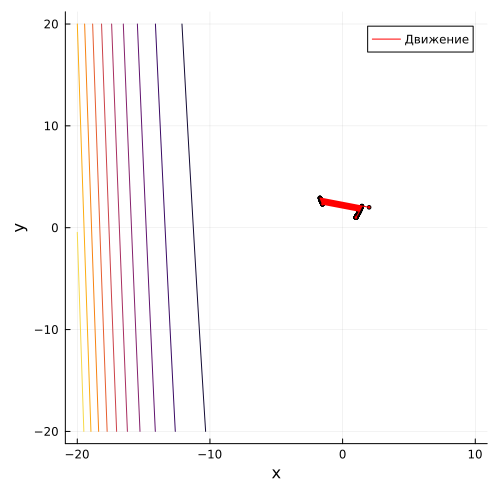

In [12]:
func(x, y) = (1-x)^2 +100*(y-x^2)^2  # розенброк
f(x) = func(x[1],x[2])
x0 = [2.0, 2.0]
print()

x = -20:0.1:10
y = -20:0.1:20
x_min, trajectory = multicriterial(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]

contour(x, y, (x, y) -> (1-x)^2 +100*(y-x^2)^2, levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("Многокритериальный поиск:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p